# Variational Non-linear LFM

In order to run this notebook yourself, you will need the dataset located here:
- Go to https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE100099

- Download the file `GSE100099_RNASeqGEO.tsv.gz`

In [1]:
import torch
from torch.nn import Parameter
from gpytorch.distributions import MultitaskMultivariateNormal, MultivariateNormal

from lafomo.models import OrdinaryLFM, MultiOutputGP
from lafomo.trainers import VariationalTrainer
from lafomo.utilities.torch import softplus
from lafomo.configuration import VariationalConfiguration
from lafomo.datasets import HafnerData
from lafomo.plot import Plotter

from matplotlib import pyplot as plt

import numpy as np

13
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]) tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])


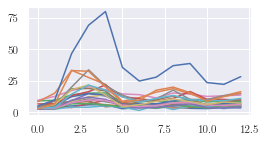

In [2]:
dataset = HafnerData(replicate=0, data_dir='../../../data/', extra_targets=False)
num_replicates = 1
num_genes = len(dataset.gene_names)
num_tfs = 1
num_times = dataset[0][0].shape[0]
print(num_times)
print(dataset[0][0], dataset.t)
t_inducing = torch.linspace(0, 12, num_times, dtype=torch.float64)
t_observed = torch.linspace(0, 12, num_times)
t_predict = torch.linspace(-2, 14, 80, dtype=torch.float64)

m_observed = torch.stack([
    dataset[i][1] for i in range(num_genes*num_replicates)
]).view(num_replicates, num_genes, num_times)

plt.figure(figsize=(4, 2))
for i in range(22):
    plt.plot(dataset[i][1])

In [3]:
class TranscriptionLFM(OrdinaryLFM):
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration):
        super().__init__(num_outputs, gp_model, config)
        self.decay_rate = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.basal_rate = Parameter(torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.sensitivity = Parameter(0.2 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))

    def initial_state(self):
        return self.basal_rate / self.decay_rate

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)

        decay = self.decay_rate * h

        f = self.f[:, :, self.t_index].unsqueeze(2)

        h = self.basal_rate + self.sensitivity * f - decay
        if t > self.last_t:
            self.t_index += 1
        self.last_t = t
        return h

    def G(self, f):
        # I = 1 so just repeat for num_outputs
        return softplus(f).repeat(1, self.num_outputs, 1)

    def predict_f(self, t_predict):
        # Sample from the latent distribution
        q_f = super().predict_f(t_predict)
        f = q_f.sample(torch.Size([500])).permute(0, 2, 1)  # (S, I, T)
        print(f.shape)
        # This is a hack to wrap the latent function with the nonlinearity. Note we use the same variance.
        f = torch.mean(self.G(f), dim=0)[0].unsqueeze(0)
        print(f.shape, q_f.mean.shape, q_f.scale_tril.shape)
        batch_mvn = MultivariateNormal(f, q_f.covariance_matrix.unsqueeze(0))
        print(batch_mvn)
        return MultitaskMultivariateNormal.from_batch_mvn(batch_mvn, task_dim=0)

class ExpTranscriptionLFM(TranscriptionLFM):

    def G(self, f):
        # I = 1 so just repeat for num_outputs
        return torch.exp(f).repeat(1, self.num_outputs, 1)

In [4]:
config = VariationalConfiguration(
    num_samples=70,
    kernel_scale=False,
    initial_conditions=False # TODO
)

num_inducing = 12  # (I x m x 1)
inducing_points = torch.linspace(0, 12, num_inducing).repeat(num_tfs, 1).view(num_tfs, num_inducing, 1)
t_predict = torch.linspace(-1, 13, 80, dtype=torch.float32)

gp_model = MultiOutputGP(inducing_points, num_tfs)
lfm = TranscriptionLFM(num_genes, gp_model, config)
plotter = Plotter(lfm, np.array(dataset.gene_names))

track_parameters = [
    'basal_rate',
    'decay_rate',
    'sensitivity',
    'gp_model.covar_module.raw_lengthscale',
]

optimizer = torch.optim.Adam(lfm.parameters(), lr=0.05)
trainer = VariationalTrainer(lfm, optimizer, dataset, track_parameters=track_parameters)

### Outputs prior to training:

torch.Size([500, 1, 80])
torch.Size([1, 80]) torch.Size([80, 1]) torch.Size([80, 80])
MultivariateNormal(loc: torch.Size([1, 80]), covariance_matrix: torch.Size([1, 80, 80]))


MultitaskMultivariateNormal(loc: torch.Size([80]))

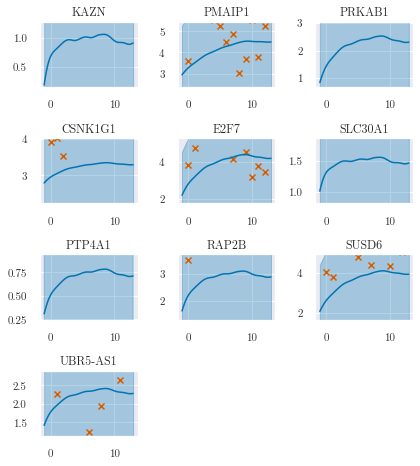

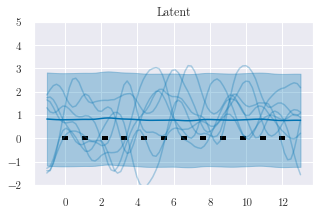

In [5]:
plotter.plot_outputs(t_predict,
                     t_scatter=t_observed,
                     y_scatter=m_observed,
                     model_kwargs=dict(step_size=1e-1))
plotter.plot_latents(t_predict,
                     ylim=(-2, 5),
                     plot_barenco=False,
                     plot_inducing=False)

In [6]:
tol = 1e-1
# trainer = Trainer(optimizer)
output = trainer.train(200, step_size=1e-1, report_interval=10)

Epoch 001/200 - Loss: 1131.87 (1131.87 0.00) λ: [0.71845967]
Epoch 011/200 - Loss: 619.39 (619.12 0.28) λ: [0.8962685]
Epoch 021/200 - Loss: 506.00 (505.61 0.39) λ: [0.75553125]
Epoch 031/200 - Loss: 312.69 (312.29 0.40) λ: [0.5512138]
Epoch 041/200 - Loss: 279.30 (278.67 0.63) λ: [0.48193628]
Epoch 051/200 - Loss: 249.43 (248.67 0.76) λ: [0.47491178]
Epoch 061/200 - Loss: 226.69 (225.91 0.77) λ: [0.49874493]
Epoch 071/200 - Loss: 205.36 (204.60 0.76) λ: [0.5405899]
Epoch 081/200 - Loss: 191.80 (191.03 0.76) λ: [0.5875011]
Epoch 091/200 - Loss: 180.23 (179.45 0.79) λ: [0.63282675]
Epoch 101/200 - Loss: 169.62 (168.79 0.83) λ: [0.6760483]
Epoch 111/200 - Loss: 160.11 (159.23 0.88) λ: [0.72237295]
Epoch 121/200 - Loss: 150.94 (150.01 0.93) λ: [0.76767385]
Epoch 131/200 - Loss: 143.71 (142.72 0.98) λ: [0.80863327]
Epoch 141/200 - Loss: 136.57 (135.53 1.04) λ: [0.8436331]
Epoch 151/200 - Loss: 130.38 (129.29 1.09) λ: [0.87033826]
Epoch 161/200 - Loss: 125.17 (124.03 1.14) λ: [0.8917834]
Ep

### Outputs after training

In [ ]:
plotter.plot_losses(trainer, last_x=100)
plotter.plot_outputs(t_predict,
                     replicate=0,
                     t_scatter=t_observed,
                     y_scatter=m_observed,
                     model_kwargs=dict(step_size=1e-1))
plotter.plot_latents(t_predict,
                     ylim=(-2, 10),
                     plot_inducing=False)

# plotter.plot_convergence(trainer)

In [ ]:
print(lfm.basal_rate)
print(lfm.decay_rate)
print(lfm.sensitivity)